In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

(2115, 22, 1000)


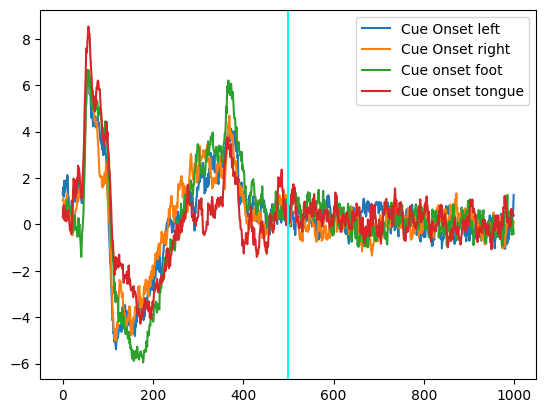

In [2]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
Y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
Y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






In [3]:
def train_data_prep(X,y,time_clips, sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:time_clips]
    # print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    # print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    # print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    # print('Shape of X after subsampling and concatenating:',total_X.shape)
    # print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X,time_clips):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:time_clips]
    # print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    # print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X




In [4]:
def data(X_train_valid,y_train_valid,X_test,Y_test,time_clips):
    ## Random splitting

    # First generating the training and validation indices using random splitting
    ind_valid = np.random.choice(2115, 200, replace=False)
    ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

    # Creating the training and validation sets using the generated indices
    X_train, X_valid = X_train_valid[ind_train], X_train_valid[ind_valid] 
    y_train, y_valid = y_train_valid[ind_train], y_train_valid[ind_valid]

    ## Preprocessing the dataset

    x_train, y_train = train_data_prep(X_train, y_train, time_clips, 2, 2, True)
    x_valid, y_valid = train_data_prep(X_valid, y_valid, time_clips, 2, 2, True)

    # print('Shape of training set:',x_train.shape)
    # print('Shape of validation set:',x_valid.shape)
    # print('Shape of training labels:',y_train.shape)
    # print('Shape of validation labels:',y_valid.shape)


    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(Y_test, 4)
    X_test_prep = test_data_prep(X_test,time_clips)
    # print('Shape of training labels after categorical conversion:',y_train.shape)
    # print('Shape of validation labels after categorical conversion:',y_valid.shape)
    # print('Shape of test labels after categorical conversion:',y_test.shape)

    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
    # print('Shape of training set after adding width info:',x_train.shape)
    # print('Shape of validation set after adding width info:',x_valid.shape)
    # print('Shape of test set after adding width info:',x_test.shape)


    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)
    # print('Shape of training set after dimension reshaping:',x_train.shape)
    # print('Shape of validation set after dimension reshaping:',x_valid.shape)
    # print('Shape of test set after dimension reshaping:',x_test.shape)

    return x_train, y_train, x_valid, y_valid, x_test, y_test

In [5]:
from tensorflow.keras.layers import GlobalAveragePooling2D

# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(5,1), padding='same', activation='elu', input_shape=(None,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(5,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(5,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(5,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(GlobalAveragePooling2D()) # Replacing Flatten with GlobalAveragePooling2D
hybrid_cnn_lstm_model.add(Reshape((1, -1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(1, None), return_sequences=False))

# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

# Printing the model summary
hybrid_cnn_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, 1, 25)       2775      
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, 1, 25)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, None, 1, 25)      100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, None, 1, 25)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, 1, 50)       6300      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, 1, 50)      0

Epoch 1/100
120/120 [==============================] - 4s 9ms/step - loss: 1.3986 - accuracy: 0.2574 - val_loss: 1.3836 - val_accuracy: 0.2900
Epoch 2/100
120/120 [==============================] - 1s 7ms/step - loss: 1.3834 - accuracy: 0.2839 - val_loss: 1.3888 - val_accuracy: 0.2625
Epoch 3/100
120/120 [==============================] - 1s 8ms/step - loss: 1.3784 - accuracy: 0.2919 - val_loss: 1.3866 - val_accuracy: 0.2812
Epoch 4/100
120/120 [==============================] - 1s 7ms/step - loss: 1.3733 - accuracy: 0.3047 - val_loss: 1.3736 - val_accuracy: 0.3237
Epoch 5/100
120/120 [==============================] - 1s 9ms/step - loss: 1.3718 - accuracy: 0.3025 - val_loss: 1.3707 - val_accuracy: 0.3075
Epoch 6/100
120/120 [==============================] - 1s 7ms/step - loss: 1.3598 - accuracy: 0.3234 - val_loss: 1.3553 - val_accuracy: 0.3537
Epoch 7/100
120/120 [==============================] - 1s 8ms/step - loss: 1.3511 - accuracy: 0.3364 - val_loss: 1.3516 - val_accuracy: 0.3725

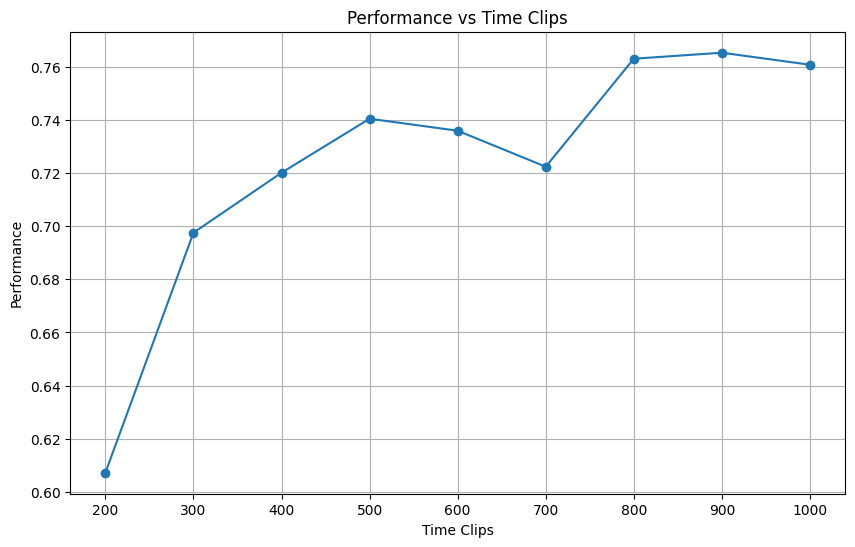

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Model parameters
learning_rate = 1e-3
epochs = 100
performance = []
time_clips = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
hybrid_cnn_lstm_optimizer = Adam(learning_rate=learning_rate)
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                    optimizer=hybrid_cnn_lstm_optimizer,
                    metrics=['accuracy'])

for i, clip in enumerate(time_clips):

    x_train, y_train, x_valid, y_valid, x_test, y_test = data(X_train_valid, y_train_valid, X_test, Y_test, clip)

    # Training and validating the model
    hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
                y_train,
                batch_size=64,
                epochs=epochs,
                validation_data=(x_valid, y_valid), verbose=True)
    
    # Testing the model
    hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
    performance.append(hybrid_cnn_lstm_score[1])
    print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])


plt.figure(figsize=(10, 6))
plt.plot(time_clips, performance, marker='o')
plt.title('Performance vs Time Clips')
plt.xlabel('Time Clips')
plt.ylabel('Performance')
plt.grid(True)
plt.show()